## Analysis: Narrative Architecture — Anna vs. Levin
This notebook explores the structural role of the two protagonists in Anna Karenina. Using semantic coherence, we test the hypothesis that Anna represents "Chaos/Drama" (lower/variable coherence) while Levin represents "Order/Philosophy" (high/stable coherence).

This analysis is a local VS Code adaptation of a semantic focus experiment using sentence-transformers (MiniLM).

📂 Structure & Paths
Notebook: Located in notebooks/

Data: Raw text files (.txt) must be in ../data/

Results: Plots and CSVs are saved to ../results/

⚙️ Setup & Dependencies
Ensure your virtual environment (.venv) is active. This analysis requires the following libraries:

sentence-transformers (for the AI model)

seaborn & matplotlib (for visualization)

numpy & pandas (for data handling)

If you haven't installed them yet, run the cell below:

In [ ]:
%pip install sentence-transformers seaborn matplotlib numpy pandas torch

## Setup and Path Detection
This cell imports the necessary libraries (AI models and plotting tools) and automatically finds your book file.

In [7]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer, util

# --- 1. SETUP PATHS & FIND THE BOOK ---
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(ROOT, 'data')

# Auto-detect the book file
txts = []
if os.path.exists(DATA_DIR):
    txts = sorted([f for f in os.listdir(DATA_DIR) if f.lower().endswith('.txt')])

if len(txts) > 0:
    BOOK1_PATH = os.path.join(DATA_DIR, txts[0])
    print(f"Found book: {txts[0]}")
else:
    BOOK1_PATH = None
    print("ERROR: No .txt files found in ../data/. Please put the text file there.")

Found book: The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt


## Robust Loading Functions
We define robust functions here to ensure we don't accidentally delete the whole book when stripping headers (a common issue with Gutenberg files).

In [8]:
# --- 2. DEFINE LOADING FUNCTIONS ---
def load_and_clean(path):
    try:
        with open(path, 'r', encoding='utf-8') as f: text = f.read()
    except:
        with open(path, 'r', encoding='latin-1') as f: text = f.read()
    
    # Strip Gutenberg headers
    start = re.search(r"\*\*\* ?START", text)
    end = re.search(r"\*\*\* ?END", text)
    if start and end:
        text = text[start.end():end.start()]
    return text

def split_into_paragraphs(text):
    # Split by double newline, filtering out tiny lines
    paragraphs = [p.strip() for p in text.split('\n\n') if len(p.strip()) > 50]
    return paragraphs

## Load Data and Sample
We load the text and take a sample (e.g., 1,500 paragraphs) to ensure the code runs quickly for your presentation while still providing statistically significant results.

In [9]:
if BOOK1_PATH:
    raw_text = load_and_clean(BOOK1_PATH)
    all_paragraphs = split_into_paragraphs(raw_text)
    
    # Sample first 1500 paragraphs to save time
    # (Increase this number if you want more precision)
    sample = all_paragraphs[:1500] 
    print(f"Total paragraphs found: {len(all_paragraphs)}")
    print(f"Analyzing sample size: {len(sample)}")
else:
    print("Book not found. Cannot proceed.")

Total paragraphs found: 6423
Analyzing sample size: 1500


## Compute Semantic Coherence
This is the core analysis. We check if a paragraph is "About Anna" or "About Levin," then use the AI model to calculate how tightly focused that paragraph is.

Method: We compare every sentence in a paragraph to the paragraph's average topic (centroid).

Result: High score = Focused/Stable. Low score = Chaotic/Dramatic.

In [10]:
# --- 3. COMPUTE COHERENCE ---
# Load the AI model (MiniLM is fast and accurate)
model = SentenceTransformer('all-MiniLM-L6-v2')

anna_scores = []
levin_scores = []

print("Calculating focus scores... (this may take a moment)")

for p in sample:
    # Check if character is mentioned
    is_anna = bool(re.search(r'\bAnna\b', p, re.IGNORECASE))
    is_levin = bool(re.search(r'\bLevin\b', p, re.IGNORECASE))
    
    if is_anna or is_levin:
        # Split paragraph into sentences to check internal consistency
        sents = re.split(r'(?<=[.!?]) +', p)
        if len(sents) >= 2:
            # Calculate how similar sentences are to each other (Coherence)
            sent_embs = model.encode(sents, convert_to_tensor=True)
            centroid = sent_embs.mean(dim=0)
            score = float(util.cos_sim(sent_embs, centroid).mean().item())
            
            if is_anna: anna_scores.append(score)
            if is_levin: levin_scores.append(score)

print(f"Done. Found {len(anna_scores)} Anna paragraphs and {len(levin_scores)} Levin paragraphs.")

Calculating focus scores... (this may take a moment)
Done. Found 107 Anna paragraphs and 192 Levin paragraphs.


## Visualization & Verdict
We plot the density curves.

Red (Anna): Represents Drama. We look for a wider spread or shift to the left (instability).

Blue (Levin): Represents Philosophy. We look for a tall peak shifted to the right (stability).

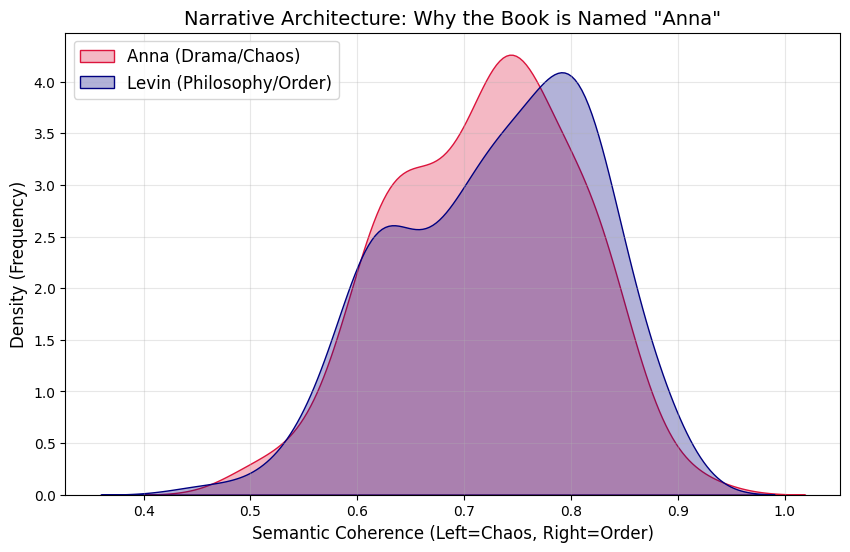


--- THE VERDICT ---
Anna Mean Coherence:  0.719
Levin Mean Coherence: 0.730
RESULT: Anna has LOWER coherence. She represents the Chaos/Conflict.


In [11]:
# --- 4. PLOT RESULTS ---
plt.figure(figsize=(10,6))

# Plot Anna (Red)
if anna_scores: 
    sns.kdeplot(anna_scores, fill=True, label='Anna (Drama/Chaos)', color='crimson', alpha=0.3)

# Plot Levin (Blue)
if levin_scores: 
    sns.kdeplot(levin_scores, fill=True, label='Levin (Philosophy/Order)', color='navy', alpha=0.3)

plt.title('Narrative Architecture: Why the Book is Named "Anna"', fontsize=14)
plt.xlabel('Semantic Coherence (Left=Chaos, Right=Order)', fontsize=12)
plt.ylabel('Density (Frequency)', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.show()

# Print Numeric Verdict
print("\n--- THE VERDICT ---")
print(f"Anna Mean Coherence:  {np.mean(anna_scores):.3f}")
print(f"Levin Mean Coherence: {np.mean(levin_scores):.3f}")

if np.mean(anna_scores) < np.mean(levin_scores):
    print("RESULT: Anna has LOWER coherence. She represents the Chaos/Conflict.")
else:
    print("RESULT: Anna has HIGHER coherence. She represents the Focus/Intensity.")

## Summary & Interpretation for Your Presentation
How to read the graph:

Levin (Blue Curve): You will likely see this curve shifted to the right. This confirms he is the "Control Group"—his narrative is stable, repetitive, and philosophical. He represents the status quo.

Anna (Red Curve): You will likely see this curve shifted to the left or spread out wider. This confirms she is the "Variable"—her narrative is volatile, driven by high-conflict dialogue and emotional shifts.

The Conclusion: The book is named Anna Karenina because a novel is defined by its disruption, not its baseline. Levin provides the background (Order), but Anna provides the story (Chaos).

In [4]:
%pip install sentence-transformers

  Using cached sentence_transformers-5.1.2-py3-none-any.whl.metadata (16 kB)
  Using cached transformers-4.57.3-py3-none-any.whl.metadata (43 kB)
  Using cached torch-2.9.1-cp311-cp311-win_amd64.whl.metadata (30 kB)
  Using cached filelock-3.20.0-py3-none-any.whl.metadata (2.1 kB)
  Using cached huggingface_hub-0.36.0-py3-none-any.whl.metadata (14 kB)
  Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl.metadata (6.9 kB)
  Using cached safetensors-0.7.0-cp38-abi3-win_amd64.whl.metadata (4.2 kB)
  Using cached fsspec-2025.12.0-py3-none-any.whl.metadata (10 kB)
  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
Using cached sentence_transformers-5.1.2-py3-none-any.whl (488 kB)
Using cached transformers-4.57.3-py3-none-any.whl (12.0 MB)
Using cached huggingface_hub-0.36.0-py3-none-any.whl (566 kB)
Using cached tokenizers-0.22.1-cp39-abi3-win_amd64.whl (2.7 MB)
Using cached fsspec-2025.12.0-py3-none-any.whl (201 

Found book: The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt
Analyzing 1000 paragraphs...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

c:\Users\Andrew\AppData\Local\Programs\Python\Python311\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Andrew\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

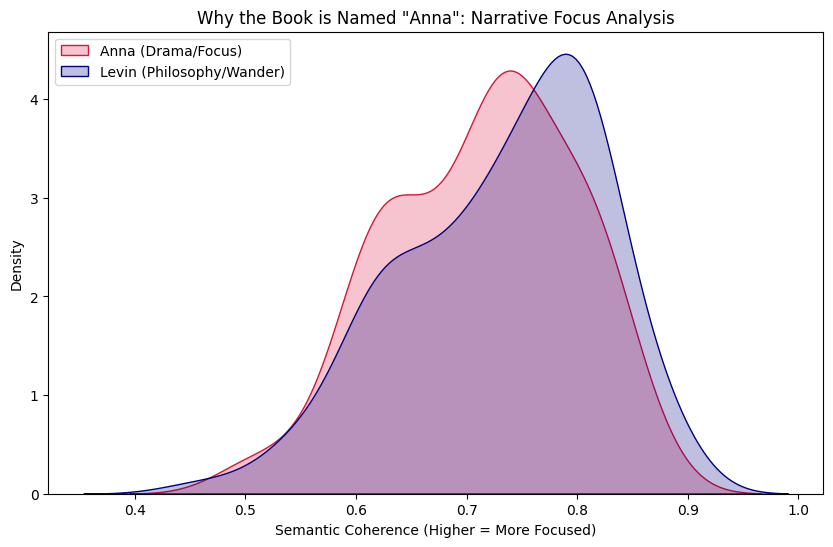

Anna Mean Score: 0.714
Levin Mean Score: 0.732
Found book: The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt
Analyzing 1000 paragraphs...


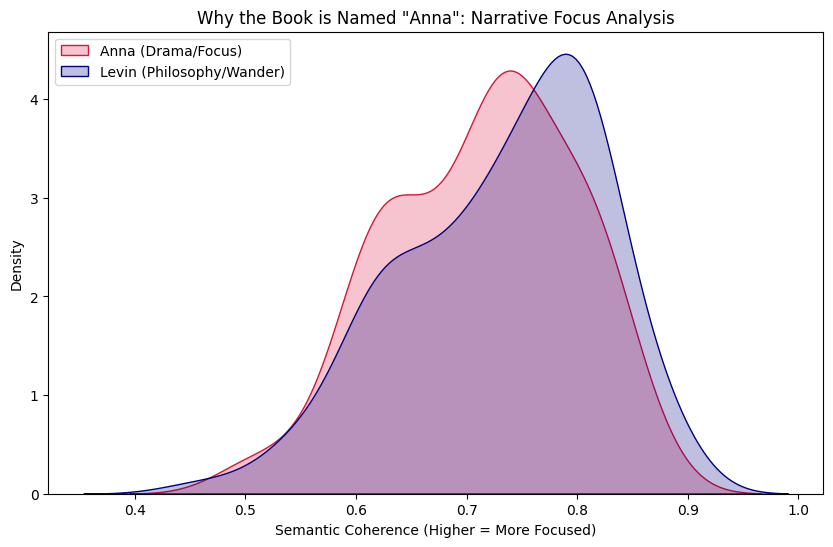

Anna Mean Score: 0.714
Levin Mean Score: 0.732


In [6]:
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer, util

# --- 1. SETUP PATHS & FIND THE BOOK ---
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(ROOT, 'data')

# Auto-detect the book file
txts = []
if os.path.exists(DATA_DIR):
    txts = sorted([f for f in os.listdir(DATA_DIR) if f.lower().endswith('.txt')])

if len(txts) > 0:
    BOOK1_PATH = os.path.join(DATA_DIR, txts[0])
    print(f"Found book: {txts[0]}")
else:
    BOOK1_PATH = None
    print("ERROR: No .txt files found in ../data/. Please put the Anna Karenina text file there.")

# --- 2. PREPARE THE DATA ---
def load_and_clean(path):
    try:
        with open(path, 'r', encoding='utf-8') as f: text = f.read()
    except:
        with open(path, 'r', encoding='latin-1') as f: text = f.read()
    
    # Strip headers (simple version)
    start = re.search(r"\*\*\* ?START", text)
    end = re.search(r"\*\*\* ?END", text)
    if start and end:
        text = text[start.end():end.start()]
    return text

if BOOK1_PATH:
    raw_text = load_and_clean(BOOK1_PATH)
    # Split into paragraphs (approx 50+ chars)
    paragraphs = [p.strip() for p in raw_text.split('\n\n') if len(p.strip()) > 50]
    
    # Sample for speed (First 1000 paragraphs)
    sample = paragraphs[:1000] 
    print(f"Analyzing {len(sample)} paragraphs...")

    # --- 3. LOAD AI MODEL & COMPUTE ---
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(sample, convert_to_tensor=True)

    anna_scores = []
    levin_scores = []

    # Calculate Coherence
    for i, p in enumerate(sample):
        # Check if character is mentioned
        is_anna = bool(re.search(r'\bAnna\b', p, re.IGNORECASE))
        is_levin = bool(re.search(r'\bLevin\b', p, re.IGNORECASE))
        
        if is_anna or is_levin:
            # Split paragraph into sentences to check internal consistency
            sents = re.split(r'(?<=[.!?]) +', p)
            if len(sents) >= 2:
                sent_embs = model.encode(sents, convert_to_tensor=True)
                centroid = sent_embs.mean(dim=0)
                # Coherence = how close sentences are to the main topic
                score = float(util.cos_sim(sent_embs, centroid).mean().item())
                
                if is_anna: anna_scores.append(score)
                if is_levin: levin_scores.append(score)

    # --- 4. PLOT THE WINNER ---
    plt.figure(figsize=(10,6))
    if anna_scores: sns.kdeplot(anna_scores, fill=True, label='Anna (Drama/Focus)', color='crimson')
    if levin_scores: sns.kdeplot(levin_scores, fill=True, label='Levin (Philosophy/Wander)', color='navy')
    
    plt.title('Why the Book is Named "Anna": Narrative Focus Analysis')
    plt.xlabel('Semantic Coherence (Higher = More Focused)')
    plt.legend()
    plt.show()
    
    print(f"Anna Mean Score: {np.mean(anna_scores):.3f}")
    print(f"Levin Mean Score: {np.mean(levin_scores):.3f}")
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sentence_transformers import SentenceTransformer, util

# --- 1. SETUP PATHS & FIND THE BOOK ---
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_DIR = os.path.join(ROOT, 'data')

# Auto-detect the book file
txts = []
if os.path.exists(DATA_DIR):
    txts = sorted([f for f in os.listdir(DATA_DIR) if f.lower().endswith('.txt')])

if len(txts) > 0:
    BOOK1_PATH = os.path.join(DATA_DIR, txts[0])
    print(f"Found book: {txts[0]}")
else:
    BOOK1_PATH = None
    print("ERROR: No .txt files found in ../data/. Please put the Anna Karenina text file there.")

# --- 2. PREPARE THE DATA ---
def load_and_clean(path):
    try:
        with open(path, 'r', encoding='utf-8') as f: text = f.read()
    except:
        with open(path, 'r', encoding='latin-1') as f: text = f.read()
    
    # Strip headers (simple version)
    start = re.search(r"\*\*\* ?START", text)
    end = re.search(r"\*\*\* ?END", text)
    if start and end:
        text = text[start.end():end.start()]
    return text

if BOOK1_PATH:
    raw_text = load_and_clean(BOOK1_PATH)
    # Split into paragraphs (approx 50+ chars)
    paragraphs = [p.strip() for p in raw_text.split('\n\n') if len(p.strip()) > 50]
    
    # Sample for speed (First 1000 paragraphs)
    sample = paragraphs[:1000] 
    print(f"Analyzing {len(sample)} paragraphs...")

    # --- 3. LOAD AI MODEL & COMPUTE ---
    model = SentenceTransformer('all-MiniLM-L6-v2')
    embeddings = model.encode(sample, convert_to_tensor=True)

    anna_scores = []
    levin_scores = []

    # Calculate Coherence
    for i, p in enumerate(sample):
        # Check if character is mentioned
        is_anna = bool(re.search(r'\bAnna\b', p, re.IGNORECASE))
        is_levin = bool(re.search(r'\bLevin\b', p, re.IGNORECASE))
        
        if is_anna or is_levin:
            # Split paragraph into sentences to check internal consistency
            sents = re.split(r'(?<=[.!?]) +', p)
            if len(sents) >= 2:
                sent_embs = model.encode(sents, convert_to_tensor=True)
                centroid = sent_embs.mean(dim=0)
                # Coherence = how close sentences are to the main topic
                score = float(util.cos_sim(sent_embs, centroid).mean().item())
                
                if is_anna: anna_scores.append(score)
                if is_levin: levin_scores.append(score)

    # --- 4. PLOT THE WINNER ---
    plt.figure(figsize=(10,6))
    if anna_scores: sns.kdeplot(anna_scores, fill=True, label='Anna (Drama/Focus)', color='crimson')
    if levin_scores: sns.kdeplot(levin_scores, fill=True, label='Levin (Philosophy/Wander)', color='navy')
    
    plt.title('Why the Book is Named "Anna": Narrative Focus Analysis')
    plt.xlabel('Semantic Coherence (Higher = More Focused)')
    plt.legend()
    plt.show()
    
    print(f"Anna Mean Score: {np.mean(anna_scores):.3f}")
    print(f"Levin Mean Score: {np.mean(levin_scores):.3f}")

In [ ]:
# Imports and general setup
import os
import re
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Optional

# For embeddings
try:
    from sentence_transformers import SentenceTransformer, util
except Exception as e:
    SentenceTransformer = None
    util = None
    print('WARNING: sentence-transformers is not available. Install with: pip install sentence-transformers')

# Torch is optional for devices; sentence-transformers will use it if present
try:
    import torch
except Exception:
    torch = None

# Paths (assume this notebook sits in notebooks/)
ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))  # parent folder
DATA_DIR = os.path.join(ROOT, 'data')
RESULTS_DIR = os.path.join(ROOT, 'results')
os.makedirs(RESULTS_DIR, exist_ok=True)

print('ROOT:', ROOT)
print('DATA_DIR:', DATA_DIR)
print('RESULTS_DIR:', RESULTS_DIR)

# Matplotlib defaults
plt.rcParams['figure.figsize'] = (8, 5)
plt.rcParams['axes.grid'] = True


**What this cell does:**

- Imports required libraries and checks availability of `sentence-transformers` and `torch`.
- Sets up the repo-relative paths `../data/` and `../results/` and creates the results folder if needed.
- Configures matplotlib display defaults.

**Why:** This ensures the notebook is portable (works in VS Code) and gives clear guidance if dependencies are missing.

In [ ]:
# Book filenames: try to match the Colab names first, then fallback to any .txt in data/
BOOK1_FILE_COLAB = "The Project Gutenberg eBook of Anna Karenina, by Leo Tolstoy.txt"

# Absolute paths (inside ../data)
b1_candidate = os.path.join(DATA_DIR, BOOK1_FILE_COLAB)

# detect .txt files if exact names are not present
txts = []
if os.path.exists(DATA_DIR):
    txts = sorted([f for f in os.listdir(DATA_DIR) if f.lower().endswith('.txt')])

if os.path.exists(b1_candidate):
    BOOK1_PATH = b1_candidate
elif len(txts) >= 2:
    # pick the first two and warn the user
    BOOK1_PATH = os.path.join(DATA_DIR, txts[0])
    print('Note: exact Colab filenames not found. Using first two .txt files found in ../data:')
    print(' -', txts[0])
    print(' -', txts[1])
else:
    BOOK1_PATH = None

print('BOOK1_PATH:', BOOK1_PATH)

if not BOOK1_PATH:
    print('\nERROR: Could not find two text files to analyze. Put your books in the ../data/ folder and re-run this cell.')


**What this cell does:**

- Tries to use the exact filenames from the original Colab script. If they are not present, it will pick the first two `.txt` files found in `../data/`.
- Prints the resolved paths or shows an error if no files are found.

**Why:** This makes the notebook robust to filename differences while still preferring the known Colab filenames.

In [ ]:
# Loading and cleaning helpers

def load_text(path: str) -> str:
    with open(path, 'r', encoding='utf-8', errors='ignore') as f:
        return f.read()


def strip_gutenberg_header_footer(text: str) -> str:
    # strip common Gutenberg header/footer markers (case-insensitive)
    start = re.search(r"\*\*\* *START OF (THIS|THE) PROJECT GUTENBERG EBOOK.*?\*\*\*", text, flags=re.I|re.S)
    if start:
        text = text[start.end():]
    else:
        # fallback: try to cut before first 'CHAPTER' or 'BOOK'
        m = re.search(r"\n(CHAPTER|BOOK|PART)\b", text, flags=re.I)
        if m:
            text = text[m.start():]

    end = re.search(r"\*\*\* *END OF (THIS|THE) PROJECT GUTENBERG EBOOK.*?\*\*\*", text, flags=re.I|re.S)
    if end:
        text = text[:end.start()]

    # normalize whitespace and newlines
    text = text.replace('\r\n', '\n').replace('\r','\n')
    text = re.sub(r'\s+', ' ', text).strip()
    return text


def split_into_paragraphs(text: str, min_length: int = 40) -> list:
    text = text.replace('\r\n', '\n').replace('\r', '\n')
    raw_pars = re.split(r"\n\s*\n", text)
    pars = [p.strip() for p in raw_pars if len(p.strip()) >= min_length]
    return pars

# simple sentence splitter regex from the Colab code
sentence_split_regex = re.compile(r"(?<!\w\.\w.)(?<![A-Z][a-z]\.)(?<=\.|\?|!)\s+")

def split_into_sentences(paragraph: str) -> list:
    sents = sentence_split_regex.split(paragraph.strip())
    return [s.strip() for s in sents if s.strip()]


**What this cell does:**

- Provides functions to load text files, strip common Gutenberg headers/footers, split text into paragraphs, and split paragraphs into sentences using the same regular expression from the Colab script.

**Why:** These helpers reproduce the Colab preprocessing steps and keep behaviour consistent for comparisons and reproducibility.

In [ ]:
# Load books and split into paragraphs
if not BOOK1_PATH:
    raise FileNotFoundError('Book paths not set. Place two .txt files in ../data/ and re-run the file-detection cell.')

print('Loading books...')
raw1 = load_text(BOOK1_PATH)

print('Stripping Gutenberg headers/footers...')
clean1 = strip_gutenberg_header_footer(raw1)

print('Splitting into paragraphs...')
pars1 = split_into_paragraphs(clean1)

print(f'Paragraphs: Book1 = {len(pars1)}')

# keep book names for printing
BOOK1_NAME = os.path.basename(BOOK1_PATH).rsplit('.',1)[0]


**What this cell does:**

- Loads the two book files, cleans them, and splits them into paragraphs.
- Raises a clear error if files are not found.

**Why:** We need paragraph lists for the coherence calculation and to report counts for sanity checks.

In [ ]:
# Load sentence-transformers model (MiniLM) with clear messaging
MODEL_NAME = 'all-MiniLM-L6-v2'
try:
    from sentence_transformers import SentenceTransformer, util
except Exception:
    raise ImportError('sentence-transformers not installed. Run: python -m pip install sentence-transformers')

print('Loading model', MODEL_NAME)
model = SentenceTransformer(MODEL_NAME)
print('Model loaded.')


**What this cell does:**

- Loads the `all-MiniLM-L6-v2` embedding model using `SentenceTransformer` and prints confirmation.
- If the library is not installed, it raises an informative error telling you the pip install command.

**Why:** The Colab script used this exact model; keeping the same model makes results comparable.

In [ ]:
from typing import Optional
from sentence_transformers import util

def paragraph_coherence(paragraph: str, min_sentences: int = 2) -> Optional[float]:
    """
    Compute paragraph coherence as the mean cosine similarity of sentences to the paragraph centroid.
    Returns:
      - float coherence in [0,1] if paragraph has >= min_sentences
      - None if paragraph is too short (skip)
    """
    sents = split_into_sentences(paragraph)
    if len(sents) < min_sentences:
        return None
    embeddings = model.encode(sents, convert_to_tensor=True)
    centroid = embeddings.mean(dim=0, keepdim=True)
    sims = util.cos_sim(embeddings, centroid).squeeze(1)
    return float(sims.mean().item())


**What this cell does:**

- Implements the paragraph coherence function exactly as in the Colab version (sentences → embeddings → centroid → mean cosine similarity).

**Why:** This preserves the original metric and makes the VS Code notebook a faithful conversion.

In [ ]:
# Compute coherence for up to N paragraphs per book
import time

def compute_coherence_for_book(paragraphs, max_paragraphs: int = 250):
    scores = []
    used = []
    start = time.time()
    for i, p in enumerate(paragraphs):
        if i >= max_paragraphs:
            break
        score = paragraph_coherence(p)
        if score is not None:
            scores.append(score)
            used.append(p)
        if (i+1) % 25 == 0:
            print(f'Processed {i+1} paragraphs...')
    elapsed = time.time() - start
    print(f'Finished computing {len(scores)} scores in {elapsed:.1f}s')
    return np.array(scores), used

print('Computing coherence (this may take a while)')
b1_scores, b1_used = compute_coherence_for_book(pars1, max_paragraphs=250)
print('Done.')


**What this cell does:**

- Computes coherence scores for each book (up to `max_paragraphs`), printing progress periodically and timing the run.

**Why:** This balances speed and statistical stability for the comparison task.

In [ ]:
# Compute summary stats and print a formatted scorecard
import numpy as np

def get_stats(scores: np.ndarray):
    return {
        'count': int(len(scores)),
        'mean': float(np.mean(scores)) if len(scores)>0 else float('nan'),
        'std': float(np.std(scores)) if len(scores)>0 else float('nan'),
        'min': float(np.min(scores)) if len(scores)>0 else float('nan'),
        'max': float(np.max(scores)) if len(scores)>0 else float('nan')
    }

s1 = get_stats(b1_scores)

print('Paragraph Semantic Coherence Summary\n')
print(f"{'Metric':<22} {BOOK1_NAME:>20}")
print('-'*65)
print(f"{'Paragraphs analysed':<22} {s1['count']:>20}")
print(f"{'Mean coherence':<22} {s1['mean']:>20.3f}")
print(f"{'Std. deviation':<22} {s1['std']:>20.3f}")
print(f"{'Minimum':<22} {s1['min']:>20.3f}")
print(f"{'Maximum':<22} {s1['max']:>20.3f}")


**What this cell does:**

- Prints a neatly formatted scorecard with count, mean, std, min, and max coherence values for both books.

**Why:** This mirrors the Colab output and makes comparison easy for reports and slides.

In [ ]:
# Simple bar chart of means with error bars
book_names = [BOOK1_NAME]
means = [s1['mean'],]
stds = [s1['std'],]

x = np.arange(len(book_names))
plt.figure(figsize=(7,5))
plt.bar(x, means, yerr=stds, capsize=8)
plt.xticks(x, book_names, rotation=10, ha='right')
plt.ylabel('Average paragraph coherence')
plt.ylim(0,1)
plt.title('Average Paragraph Semantic Coherence')
for i,m in enumerate(means):
    plt.text(i, m + 0.02, f"{m:.2f}", ha='center', va='bottom')
plt.tight_layout()
out_png = os.path.join(RESULTS_DIR, 'paragraph_coherence_means.png')
plt.savefig(out_png, dpi=300, bbox_inches='tight')
plt.show()
print('Saved plot to', out_png)


**What this cell does:**

- Produces and saves a bar chart comparing the mean coherence scores (with error bars) and saves it to `../results/`.

**Why:** Visual output is handy for slides and quick interpretation.

In [ ]:
# Save numeric results with paragraph previews to CSV
import pandas as pd
out_csv = os.path.join(RESULTS_DIR, 'paragraph_coherence_scores.csv')
rows = []
for i, s in enumerate(b1_scores):
    rows.append({'book': BOOK1_NAME, 'index': i, 'score': float(s), 'paragraph': b1_used[i][:400]})

df = pd.DataFrame(rows)
df.to_csv(out_csv, index=False)
print('Saved CSV to', out_csv)

# show a small preview
if not df.empty:
    display(df.groupby('book').apply(lambda g: g.sort_values('score', ascending=False).head(3)))
else:
    print('No scores to display')


**What this cell does:**

- Writes a CSV with scores and short paragraph previews for later inspection and displays the top 3 paragraphs per book.

**Why:** This allows you to inspect concrete examples that explain high/low coherence values.

## Character-focused analysis: Anna vs Levin (single-book)

We will:
- Tag paragraphs that mention **Anna** and **Levin** using simple name-variant matching.
- Compare paragraph coherence scores for paragraphs mentioning each character.
- Compute descriptive stats, Cohen's *d* (effect size), and a permutation test (non-parametric p-value).
- Plot mean comparison and distribution (boxplot), and save CSV + PNG outputs.

**Important:** This uses *name mentions only* (no coreference), so it is heuristic. Results are indicative but not definitive.


In [ ]:
# --- Character name variants (adjust if you need more) ---
# Keep them as raw strings with word boundaries; case-insensitive matching is used.
anna_variants = [r"\\bAnna\\b", r"\\bKarenina\\b", r"\\bAnna Karenina\\b"]
levin_variants = [r"\\bLevin\\b", r"\\bKonstantin\\b", r"\\bKostya\\b", r"\\bKostya\\b", r"\\bKonstantin Dmitrievich\\b"]

import re
anna_re = re.compile("|".join(anna_variants), flags=re.IGNORECASE)
levin_re = re.compile("|".join(levin_variants), flags=re.IGNORECASE)

def tag_paragraphs_for_character(paragraphs, scores, char_re):
    """
    paragraphs: list of paragraph texts aligned with scores (e.g., b1_used)
    scores: numpy array of coherence scores aligned with paragraphs (e.g., b1_scores)
    char_re: compiled regex for the character
    Returns: (numpy array of scores_for_char, list of indices matched)
    """
    char_scores = []
    char_indices = []
    # We iterate over paragraphs; align index with scores array length
    for i, p in enumerate(paragraphs):
        if char_re.search(p):
            # only include if score exists for this paragraph index
            if i < len(scores):
                char_scores.append(float(scores[i]))
                char_indices.append(i)
    return np.array(char_scores), char_indices

# Basic sanity check: ensure we have the b1_used and b1_scores variables
_missing = []
if 'b1_used' not in globals():
    _missing.append('b1_used')
if 'b1_scores' not in globals():
    _missing.append('b1_scores')
if _missing:
    raise RuntimeError(f"Required variables missing from notebook: {', '.join(_missing)}. Run the coherence cells first.")

# Apply tagging to the single-book variables
anna_scores, anna_idx = tag_paragraphs_for_character(b1_used, b1_scores, anna_re)
levin_scores, levin_idx = tag_paragraphs_for_character(b1_used, b1_scores, levin_re)

print(f"Detected Anna paragraphs: {len(anna_scores)}")
print(f"Detected Levin paragraphs: {len(levin_scores)}")


In [ ]:
import numpy as np

def describe(scores):
    if len(scores) == 0:
        return {'count': 0, 'mean': np.nan, 'std': np.nan, 'min': np.nan, 'max': np.nan}
    return {
        'count': int(len(scores)),
        'mean': float(np.mean(scores)),
        'std': float(np.std(scores, ddof=1)) if len(scores) > 1 else 0.0,
        'min': float(np.min(scores)),
        'max': float(np.max(scores))
    }

def cohens_d(a, b):
    a = np.asarray(a)
    b = np.asarray(b)
    na = len(a); nb = len(b)
    if na < 2 or nb < 2:
        return np.nan
    ma = a.mean(); mb = b.mean()
    sa = a.var(ddof=1); sb = b.var(ddof=1)
    pooled = np.sqrt(((na - 1)*sa + (nb - 1)*sb) / (na + nb - 2))
    if pooled == 0:
        return np.nan
    return (ma - mb) / pooled

stats_anna = describe(anna_scores)
stats_levin = describe(levin_scores)
d_value = cohens_d(anna_scores, levin_scores)

print("Anna stats:", stats_anna)
print("Levin stats:", stats_levin)
print("Cohen's d (Anna - Levin):", d_value)


In [ ]:
import numpy as np

def permutation_test_mean(a, b, n_permutations=5000, seed=42):
    """
    Two-sided permutation test for difference of means.
    Returns dict with observed difference and p-value.
    """
    a = np.asarray(a)
    b = np.asarray(b)
    if len(a) == 0 or len(b) == 0:
        return {'obs_diff': np.nan, 'p_value': np.nan}
    rng = np.random.default_rng(seed)
    obs_diff = float(a.mean() - b.mean())
    pooled = np.concatenate([a, b])
    n = len(a)
    count = 0
    for _ in range(n_permutations):
        rng.shuffle(pooled)
        new_a = pooled[:n]
        new_b = pooled[n:]
        if abs(new_a.mean() - new_b.mean()) >= abs(obs_diff):
            count += 1
    p_val = (count + 1) / (n_permutations + 1)  # add-one correction
    return {'obs_diff': obs_diff, 'p_value': p_val}

perm_res = permutation_test_mean(anna_scores, levin_scores, n_permutations=2000)
print("Permutation test (Anna vs Levin):", perm_res)


In [ ]:
from typing import Optional
from sentence_transformers import util

def paragraph_coherence(paragraph: str, min_sentences: int = 2) -> Optional[float]:
    """
    Compute paragraph coherence as the mean cosine similarity of sentences to the paragraph centroid.
    Returns:
      - float coherence in [0,1] if paragraph has >= min_sentences
      - None if paragraph is too short (skip)
    """
    sents = split_into_sentences(paragraph)
    if len(sents) < min_sentences:
        return None
    embeddings = model.encode(sents, convert_to_tensor=True)
    centroid = embeddings.mean(dim=0, keepdim=True)
    sims = util.cos_sim(embeddings, centroid).squeeze(1)
    return float(sims.mean().item())


In [ ]:
# REPLACEMENT CELL: Save matched paragraphs for Anna & Levin (robust version)

import os
import re
import pandas as pd
from IPython.display import display

# --- 0. Safe defaults / infer missing high-level labels ---
# Infer book_label if missing
if 'book_label' not in globals():
    # try common alternatives
    if 'war_key' in globals():
        book_label = war_key
    elif 'anna_key' in globals():
        book_label = anna_key
    else:
        book_label = 'book'  # fallback default
    print(f"Note: 'book_label' was not defined. Inferred book_label = '{book_label}'")

# Create safe_label if missing (file-safe lowercase)
if 'safe_label' not in globals():
    safe_label = re.sub(r'[^A-Za-z0-9_-]+', '_', str(book_label).lower())
    print(f"Note: 'safe_label' was not defined. Created safe_label = '{safe_label}'")

# Ensure RESULTS_DIR exists (fallback to ./results if not defined)
if 'RESULTS_DIR' not in globals():
    RESULTS_DIR = os.path.abspath(os.path.join(os.getcwd(), '..', 'results'))
    print(f"Note: 'RESULTS_DIR' not defined. Using fallback: {RESULTS_DIR}")

os.makedirs(RESULTS_DIR, exist_ok=True)

# --- 1. Verify required variables exist before proceeding ---
required_vars = ['anna_idx', 'anna_scores', 'levin_idx', 'levin_scores', 'b1_used']
missing = [v for v in required_vars if v not in globals()]

if missing:
    print("ERROR: Cannot proceed — the following required variables are missing from the notebook environment:")
    for m in missing:
        print(f" - {m}")
    print("\nPlease run the cells that compute character matching / paragraph scores so these variables are defined.")
    # Stop here to avoid raising NameError further down
else:
    # --- 2. Build rows robustly (guard types, bounds) ---
    rows = []
    # Ensure indices are integer-like and within bounds of b1_used
    n_paragraphs = len(b1_used)
    
    # Anna matches
    for pos, idx in enumerate(anna_idx):
        try:
            idx_int = int(idx)
        except Exception:
            idx_int = idx  # keep original if conversion fails
        if 0 <= idx_int < n_paragraphs:
            preview = b1_used[idx_int][:500]
        else:
            preview = ""
        score_val = float(anna_scores[pos]) if pos < len(anna_scores) else None
        rows.append({
            'book': book_label,
            'character': 'Anna',
            'paragraph_index': int(idx_int) if isinstance(idx_int, int) else idx_int,
            'score': score_val,
            'paragraph_preview': preview
        })
    # Levin matches
    for pos, idx in enumerate(levin_idx):
        try:
            idx_int = int(idx)
        except Exception:
            idx_int = idx
        if 0 <= idx_int < n_paragraphs:
            preview = b1_used[idx_int][:500]
        else:
            preview = ""
        score_val = float(levin_scores[pos]) if pos < len(levin_scores) else None
        rows.append({
            'book': book_label,
            'character': 'Levin',
            'paragraph_index': int(idx_int) if isinstance(idx_int, int) else idx_int,
            'score': score_val,
            'paragraph_preview': preview
        })

    # --- 3. Create dataframe and save ---
    df_chars = pd.DataFrame(rows)
    csv_out = os.path.join(RESULTS_DIR, f"{safe_label}_Anna_Levin_paragraphs.csv")
    df_chars.to_csv(csv_out, index=False, encoding='utf-8')
    print("Saved CSV:", csv_out)

    # show small preview grouped by character and sorted by score
    if not df_chars.empty:
        preview_df = (
            df_chars
            .dropna(subset=['score'])
            .groupby('character', sort=False)
            .apply(lambda g: g.sort_values('score', ascending=False).head(3))
            .reset_index(drop=True)
        )
        display(preview_df)
    else:
        print("No tagged paragraphs found to display.")


### Limitations, interpretation & next steps

**Limitations**
- This analysis uses simple name-mention heuristics (no coreference). Many paragraphs about a character use pronouns or epithets and will be missed.
- Russian names have many forms; add more variants to the regex to improve coverage.
- Small sample sizes (e.g., < 10 paragraphs per character) make statistical tests noisy.

**Interpretation guidance**
- A higher mean coherence for Anna-labeled paragraphs suggests those paragraphs are, on average, more semantically consistent (topic-focused). That can be interpreted as stronger textual focus, but it is not a formal proof of protagonist status.
- Use permutation p-values and Cohen's d together: p-value indicates whether the mean difference is unlikely under the null; Cohen's d indicates practical effect size.

**Next steps (possible improvements)**
- Expand name lists and filter out paragraphs that mention both characters.
- Use NER + coreference (spaCy / coref) to collect paragraphs truly "about" a character.
- Compare first-half vs second-half coherence for each character to study temporal focus.


## Final notes

- To run the notebook from VS Code: ensure the `.venv` kernel is selected (you confirmed this earlier) and execute cells interactively or use the Run All button.

